# **CS224W - Colab 1**

在这个 Colab 中，我们将写一个**学习网络嵌入**的完整pipeline。
我们将这个过程分三步。

首先，我们将载入一个网络科学中经典的网络—— [空手道俱乐部网络](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). 我们将探索这个图的多个图统计量。

之后，我们将图结构转化为 PyTorch 张量，以便在图上使用机器学习。

最后，我们将完成第一个图上的学习算法：一个节点嵌入模型。为了简单起见，我们的模型比课程中的 DeepWalk/ Node2vec 算法更简单。不过在 Pytorch 上从零写起来也是有好处、有挑战的。

废话不多说，咱们开始吧！

**注意**：确保**顺序执行所有的单元**，以确保中间变量 / 库会正常传递到下一个单元中~


# 1 图基础
首先，我们将载入一个网络科学中经典的网络—— [空手道俱乐部网络](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). 我们将探索这个图的多个图统计量。

## Setup
我们在这个 Colab 中会疯狂使用 NetworkX


In [1]:
import networkx as nx

## Zachary 的空手道俱乐部网络

[空手道俱乐部网络](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) 是描述一个 34 人空手道俱乐部成员的网络，连接表示在俱乐部外这些成员也是有互动的。


In [2]:
G = nx.karate_club_graph()

# G 是一个无向图
type(G)

networkx.classes.graph.Graph

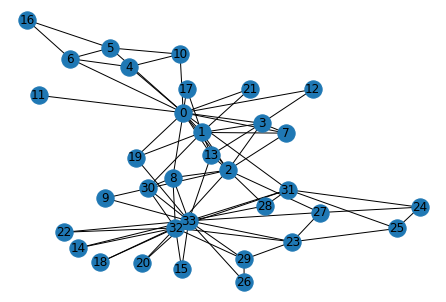

In [3]:
# 可视化这张图
nx.draw(G, with_labels = True)

## 问题 1: 这个空手道网络的平均度是多少？

In [4]:
def average_degree(num_edges, num_nodes):
    '''
    TODO: 实现函数，该函数接收边和节点数为输入，并且返回整张图的平均度数。
    请将平均度数取整数（四舍五入）
    '''

    avg_degree = 0

    ############# Your code here ############
    avg_degree = int(round(num_edges * 2 / num_nodes)) # 图论知识：平均度数是(边数 * 2) / 节点数
    #########################################

    return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## 问题 2: 这个空手道网络的平均聚类因子是多少？


In [5]:
def average_clustering_coefficient(G):
    '''
    TODO: 实现函数，该函数接收 nx.Graph 为输入，并且返回整张图的平均聚类因子。
    请将平均度数取小数点后两位（四舍五入）
    '''    

    avg_cluster_coef = 0

    ############# Your code here ############
    '''
    注意：请使用合适的 NetworkX 聚类函数
    '''
    avg_cluster_coef = nx.average_clustering(G) # nx 有这个的实现，不用自己算的！
    avg_cluster_coef = round(avg_cluster_coef, 2)
    #########################################

    return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


## 问题 3: 一次迭代后，节点 0 （id 为 0 的节点) 的 PageRank 数值是多少？

请实现以下 PageRank 公式来完成下面的代码块：
 $$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$$

In [6]:
def one_iter_pagerank(G, beta, r0, node_id):
    '''
    TODO: 实现函数，该函数接收 nx.Graph, beta, r0, 和节点 id 为输入，
    并且返回 r1，即一次迭代后输入节点的 PageRank 值。
    请将平均度数取小数点后两位（四舍五入）
    '''        
    r1 = 0

    ############# Your code here ############
    '''
    注意：别用现成的 nx.pagerank
    '''    
    # 大概流程：获取 id-th 节点的邻居，遍历邻居：
    #     获取邻居对应的出度（无向图，出度就是度数），按公式计算第一项并累加。
    # 乘以beta，加上第二项
    for ni in nx.neighbors(G, node_id): # 遍历 G 中 node_id 节点的邻居 ni
        di = G.degree[ni] # 获取 ni 的度数
        r1 += r0 / di
    r1 = beta * r1 + (1 - beta) * (1 / G.number_of_nodes()) 
    r1 = round(r1, 2)
    #########################################

    return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


## 问题 4：空手道俱乐部网络节点 5 的（原始）紧密中心度（(raw) closeness centrality）是多少？ 
接近中心度的计算公式为：
$$c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$$

具体的参见，[nx紧密中心度文档](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html)

查了文档以后，发现课程里只介绍了原始的紧密中心度，实际上nx使用的是归一化后的，归一化的计算方法差不多是：

$$c(v) = \frac{1}{AVG_{u \neq v}\text{shortest path length between } u \text{ and } v}$$

$$
c(v)=\frac{n-1}{\sum_{u=1}^{n-1} d(u, v)}
$$
换句话说，在 nx 返回的结果除以 N-1 就行~

PS： 这里还给了一个从头算一次的版本，因为 NX 里面[最短路](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html)这个函数我的确需要用到


In [7]:
def closeness_centrality(G, node=5):
    '''
    TODO: 实现函数，该函数接收 nx.Graph（空手道俱乐部）, 节点的 id 为输入，
    并且返回该空手道俱乐部指定节点的紧密中心度。
    请将平均度数取小数点后两位（四舍五入）
    '''      
    closeness = 0
    

    '''
    注意：
    1. 可使用 networkx 的紧密中心度函数
    2. networkx 的紧密中心度函数返回的是 Normalized 后的数值，和我们要求的“原始（raw）”不一致
    具体咋不一样，可以看一下课程内容~
    '''
    norm_clossness = nx.algorithms.centrality.closeness_centrality(G, u = node)
    N = G.number_of_nodes()
    raw_clossness = norm_clossness / (N - 1)
    closeness = round(raw_clossness,2) 
        
    #########################################

    return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The karate club network has closeness centrality {}".format(closeness))

The karate club network has closeness centrality 0.01


In [8]:
'''
来都来了，重新算一遍咋样？
'''
def closeness_centrality(G, node=5): 
    closeness = 0
    
    # 首先，计算 node 与其他点之间的最短路径
    # https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html
    shortest_paths = nx.shortest_path_length(G, source = node)
    # 返回一个节点 id → 距离的字典
    # print(shortest_paths)
    paths_sum = 0
    for i in range(G.number_of_nodes()):
        # 遍历所有节点（除了自身）
        paths_sum += shortest_paths[i] # 不过因为本来自己到自己的距离是0，因此不需要判断是不是自身
            
    
    raw_clossness = 1 / paths_sum 
    closeness = round(raw_clossness,2) 
        
    #########################################

    return closeness

node = 5
closeness = closeness_centrality(G, node=node)
print("The karate club network has closeness centrality {}".format(closeness))


The karate club network has closeness centrality 0.01


# 2 化图为 Tensor
之后我们一起把图 $G$ 转为一个 Pytorch tensor, 以便之后对图进行机器学习.

## Setup
请确保 Pytorch 已安装



In [9]:
import torch
print(torch.__version__)

1.7.1


## PyTorch tensor 基础

我们可以用全 0、全 1 和随机变量创建 Pytorch Tensor.


In [10]:
# 生成 3 x 4 的全 1 Tensor
ones = torch.ones(3, 4)
print(ones)

# 生成 3 x 4 的全 0 Tensor
zeros = torch.zeros(3, 4)
print(zeros)

# 生成 3 x 4 的 Tensor，元素为取值在 [0,1) 之间的随机变量
random_tensor = torch.rand(3, 4)
print(random_tensor)

# 获取 Tensor 的形状
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.8991, 0.5759, 0.2531, 0.2136],
        [0.3259, 0.8205, 0.1007, 0.0710],
        [0.6345, 0.6666, 0.5523, 0.7365]])
torch.Size([3, 4])


一个 PyTorch tensor 的所有元素都属于同一个数据类型，`dtype`.

PyTorch tensor contains elements for a single data type, the `dtype`.

In [11]:
# 生成 3 x 4 的全 0，32-位浮点数 Tensor
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# 将 Tensor 强制类型转换为 64 位的整数
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## 问题5：获取空手道俱乐部网络的边缘列表，并将其转化为 `torch.LongTensor`。 `pos_edge_index` 张量的 `torch.sum` 值是多少？ 



In [12]:
def graph_to_edge_list(G):
    '''
    TODO: 实现函数，该函数接收 nx.Graph（空手道俱乐部）为输入，
    并且返回 nx.Graph 对应的边缘列表，该列表的元素是元组，表示连接的两个点
    ''' 
    edge_list = []

    ############# Your code here ############
    for edge in G.edges(): # 就……这么简单，毕竟这个图本来就是按照元组存的边
        edge_list.append(edge)
    #########################################

    return edge_list

def edge_list_to_tensor(edge_list):
    '''
    TODO: 实现函数，该函数接收边缘列表（元组的列表） edge_list 为输入，
    并且返回边缘列表转换的 Tensor，形状为[2 x len(edge_list)].。
    ''' 
    edge_index = torch.tensor([])

    ############# Your code here ############
    edge_index = torch.LongTensor(edge_list) # emmm，就当学习一下强制类型转换
    edge_index = edge_index.t() # 为了满足形状要求，还得 .t() 转置
    #########################################

    return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


In [13]:
# 不太放心所以打一下结果看看
print(pos_edge_list)
print(pos_edge_index)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  4,
          4,  5,  5,  5,  6,  8,  8,  8,  9, 13, 14, 14, 15, 15, 18, 18, 19, 20,
         20, 22, 22, 23, 23, 23, 23, 23

## 问题6：请实现以下采样负边的函数。 然后你会回答空手道俱乐部网络中哪些边（edge_1 到 edge_5）可以是负的？

所谓**负边就是不存在于图中的边**，因此我们需要一个判断边是否存在于图中的函数，并且最好一次性获取所有存在（or 不存在）的边，方便我们进行采样。



### Preliminaries: NX 关于边存在性的函数 
这块本来文件没有的，不用找了（

In [14]:
print('边的存在性检验')
print(G.has_edge(1,0)) #判断图 G 是否存在从 1 到 0 的边

print('其实可以直接变成')
print(nx.non_edges(G)) # 这个返回不存在的边
for non_edge in nx.non_edges(G): # 所以说这玩意类似个迭代器
    print(non_edge)
    break
# 可以通过索引获取 non_edges 函数返回的元素：
for i,e in enumerate(nx.non_edges(G)):
    print(i)
    print(e)
    break
# 将 non_edges 转为 list
non_edges = list(enumerate(nx.non_edges(G)))
print(len(non_edges),non_edges[1])
# 当然，也不用这样强行把索引加进来
non_edges = list(nx.non_edges(G))
print(len(non_edges), non_edges[1])

print('自环，重复边检验')
# EX：因为下面的题目说到了，先检测一下这些 non_edges 有没有自环，以及会不会多次出现（比如同时有 (1,0) (0,1)）
flag_self_loop = 0
for edges in non_edges:
    if edges[0] == edges[1]:
        print(edges[0],edges[1],'自环！')
        flag_self_loop = 1
        break
print("Non_edges 不存在自环") if flag_self_loop == 0 else print("Non_edges 存在自环")
# print(non_edges)

source = non_edges[0][0]
end = non_edges[0][1]
flag_repeat = 0
for edges in non_edges[1:]:
    if(source == edges[1] and end == edges[0]):
        print("重复！")
        flag_repeat = 1
        break 
print("Non_edges 不存在重复") if flag_repeat == 0 else print("Non_edges 存在重复")

# 白担心了……

边的存在性检验
True
其实可以直接变成
<generator object non_edges at 0x7f3fc2ea85f0>
(0, 32)
0
(0, 32)
483 (1, (0, 33))
483 (0, 33)
自环，重复边检验
Non_edges 不存在自环
Non_edges 不存在重复


In [15]:
import random

def sample_negative_edges(G, num_neg_samples):
    '''
    TODO: 实现函数，输入为 nx.Graph G,以及所需的负边采样数，
    返回一个由负边组成的列表。现在无需考虑负边够不够多之类的边界条件。
    在这个实现中自环不能被考虑（不算正边也不算负边），
    除此之外，因为空手道俱乐部是个无向图，如果 (0,1) 都tm是正的了，你觉得 (1,0) 可能是负的吗？
    '''
    neg_edge_list = []

    ############# Your code here ############
    non_edges = list(nx.non_edges(G))
    neg_edge_list = random.sample(non_edges, num_neg_samples)
    #########################################

    return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
## Note:
## 1: For each of the 5 edges, print whether it can be negative edge
edge_candidate = [edge_1, edge_2, edge_3, edge_4, edge_5]
for i, edge in enumerate(edge_candidate):
    print('edge_{}'.format(i+1) + ("不是" if G.has_edge(edge[0], edge[1]) else "是") + "负边")
#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
edge_1不是负边
edge_2是负边
edge_3不是负边
edge_4不是负边
edge_5是负边


# 3 节点嵌入学习

最终，我们终于可以完成第一个图上的学习算法了：节点嵌入模型


## Setup

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

1.7.1


为了写出我们的节点嵌入学习方法，我们将大量使用 Pytorch 的 [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) 模块.

让我们看看如何使用 `nn.Embedding`:


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [17]:

# 初始化一个嵌入层
# 假设我们要对 4 个元素（比如节点）进行嵌入，每个元素都会被表示成一个 8 维的向量

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


我们可以直接使用 Tensor 的索引选取嵌入矩阵中某个元素对应的嵌入

We can select items from the embedding matrix, by using Tensor indices

In [18]:
# 在 emb_sample 中选取一个嵌入
id = torch.LongTensor([1])
print(emb_sample(id))

# 选取多个嵌入
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# 获取嵌入权重的矩阵
shape = emb_sample.weight.data.shape
print(shape)

# 将权重用全 1 的 Tensor 覆盖
emb_sample.weight.data = torch.ones(shape)

# Ok,现在我们看看 emb 是不是真的被初始化了
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.1381, -1.4252,  0.0327,  0.6203,  0.7247, -1.9988, -1.8531, -1.0136]],
       grad_fn=<EmbeddingBackward>)
tensor([[ 0.1381, -1.4252,  0.0327,  0.6203,  0.7247, -1.9988, -1.8531, -1.0136],
        [ 0.7999,  1.0331,  1.0393, -1.0078,  1.1628, -1.2605, -0.1370,  2.1198]],
       grad_fn=<EmbeddingBackward>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward>)


现在轮到你给咱们的图创建节点嵌入矩阵辣！
- 我们想将空手道俱乐部网络的每个向量嵌入为 **16 维向量**。
- 我们希望使用取值 $[0, 1)$ 的**均匀分布**初始化这个矩阵，并且推荐使用  [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html) 函数。


In [19]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
    '''
    TODO：实现函数，这个函数将创建节点嵌入矩阵，其实按照输入的 num_node 和 embedding_dim 返回一个 torch.nn.Embedding 层就好了
    不过记得把层的权重初始化为均匀分布哦~
    '''
    emb = None

    ############# Your code here ############
    emb = nn.Embedding(num_embeddings = num_node, embedding_dim = embedding_dim)
    shape = emb.weight.data.shape
    emb.weight.data = torch.rand(shape)
    #########################################

    return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward>)


## 可视化初始的节点嵌入
理解嵌入矩阵的一种好方法是在 2D 空间中对其进行可视化。
在这里，我们已经为你实现了嵌入可视化功能。
我们首先进行 PCA 以将嵌入的维度降低到 2D 空间。（注意之前要把数据转成 numpy）
然后可视化每个点，由它所属的社区着色。


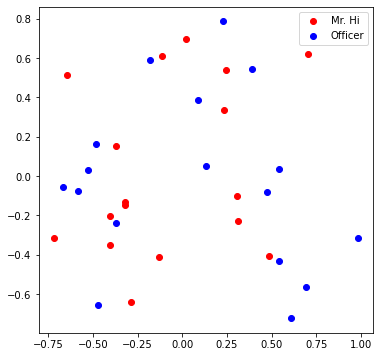

In [20]:
def visualize_emb(emb):
    X = emb.weight.data.numpy()
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    plt.figure(figsize=(6, 6))
    club1_x = []
    club1_y = []
    club2_x = []
    club2_y = []
    for node in G.nodes(data=True):
        if node[1]['club'] == 'Mr. Hi':
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
        else:
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    plt.legend()
    plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## 问题 7: 训练这个嵌入吧！你能做把 loss 和 accuracy 做的多好？



In [21]:
from torch.optim import SGD

def accuracy(pred, label):
    '''
    TODO：实现精度函数，它接收预测向量（Sigmoid 之后的分类结果）以及标签向量（torch.LongTensor）
    预测值大于 0.5 就被认为分到 label 1 里，反之则是 label 0
    返回的精度应该被四舍五入至小数点后 4 位
    '''
    accu = 0.0

    ############# Your code here ############
    # 二分类问题，代码不用很复杂
    true = ((pred>0.5) == label).sum().item()
    accu = true / len(pred)
    accu = round(accu, 4)
    #########################################

    return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
    '''
    TODO：在这里训练嵌入层。可以改变 epochs 和学习率。大体上你要实现：
    1. 获取 train_edge 中节点的嵌入
    2. 在每个节点对之间点乘嵌入向量
    3. 把点乘的结果喂给 sigmoid
    4. 把 Sigmoid 的结果喂给损失函数 loss_fn
    5. 在每个 epoch 打印 loss 和 accuracy
    ps：作为完整性检查(sanity check) 损失函数应该在训练中下降
    '''
    epochs = 500
    learning_rate = 0.1

    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for i in range(epochs):

        ############# Your code here ############
        optimizer.zero_grad()
        train_emb_0 = emb(train_edge[0])
        train_emb_1 = emb(train_edge[1])
        dot_product = torch.mul(train_emb_0, train_emb_1) # torch.dot 需要输入一维张量，所以这里只能先按位乘了
        dot_product = dot_product.sum(dim = 1)
        sig_dot = sigmoid(dot_product)
        
        loss = loss_fn(sig_dot, train_label)
        loss.backward()
        optimizer.step()
        if i%10 == 0:
            print("Loss: {}, ACC: {}".format(loss, accuracy(sig_dot, train_label)))
        
        #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

Loss: 2.013820171356201, ACC: 0.5
Loss: 1.522114634513855, ACC: 0.5
Loss: 0.9322096705436707, ACC: 0.5064
Loss: 0.6491250991821289, ACC: 0.6026
Loss: 0.5399026274681091, ACC: 0.7372
Loss: 0.48661673069000244, ACC: 0.7821
Loss: 0.449209600687027, ACC: 0.8333
Loss: 0.41647249460220337, ACC: 0.8718
Loss: 0.3853209912776947, ACC: 0.8846
Loss: 0.35494130849838257, ACC: 0.9167
Loss: 0.32523369789123535, ACC: 0.9231
Loss: 0.296368271112442, ACC: 0.9487
Loss: 0.2686227262020111, ACC: 0.9551
Loss: 0.24230095744132996, ACC: 0.9615
Loss: 0.2176826447248459, ACC: 0.9679
Loss: 0.19499137997627258, ACC: 0.9872
Loss: 0.17437447607517242, ACC: 0.9872
Loss: 0.15589120984077454, ACC: 0.9936
Loss: 0.13951082527637482, ACC: 1.0
Loss: 0.12512366473674774, ACC: 1.0
Loss: 0.11256390064954758, ACC: 1.0
Loss: 0.10163606703281403, ACC: 1.0
Loss: 0.09213773161172867, ACC: 1.0
Loss: 0.08387503027915955, ACC: 1.0
Loss: 0.07667142897844315, ACC: 1.0
Loss: 0.07037147134542465, ACC: 1.0
Loss: 0.06484121084213257, ACC

## 可视化最终的节点嵌入

在这里可视化最终的节点嵌入吧！

你可以比较下面的图和之前图的区别~
选前之后，你应该能发现两个类别的节点被明显的分开了！
这也是对你实现的一个很好的完整性检验哦！


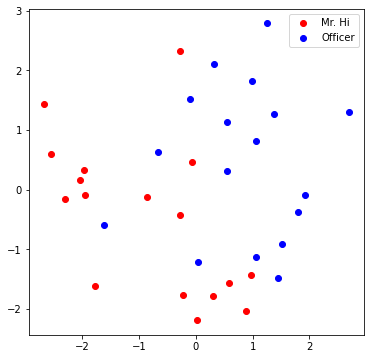

In [22]:
# Visualize the final learned embedding
visualize_emb(emb)

# Submission

In order to get credit, you must go submit your answers on Gradescope.
